<a href="https://colab.research.google.com/github/beccashamus23/CC_object_removal/blob/main/Teachable_Machine_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIRE199 Final Report
## Teachable Machine Model
### Jane Mendez


### Loading Models and Labels
I created a machine learning model with Google's Teachable Machine. To train the model, I added about 40-45 images with many unique examples for each category. Once the model is trained, I exported the code to this notebook and loaded in the models and labels that will be used throughout. In order for everything to work properly, I must import the necessary libraries. 

In [ ]:
# Importing the neccessary libraries
import pandas as pd # Pandas will help us read the GLOBE observation data from .csv files on our drive
from google.colab import drive # We import drive so that we can mount our FIRE-CC drive to the Colab environment
drive.mount('/content/gdrive', force_remount = True) # this comand is how we tell google we have permission to access the data on drive
import matplotlib.pyplot as plt # Matplotlib will allow us to make visuals of our data and display images
from keras.models import load_model # Used to load the Teachable Machine Model
from PIL import Image, ImageOps # PIL offers support for editing and saving photos
import numpy as np # Numpy will allow us to make more efficient calculations on large datasets
import csv # Offers support for opening .csv files
import urllib.request  # to obtain image from website link
import shutil # used for removing directories

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model1 = load_model('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Model 1 (Keras)/keras_model.h5', compile = False)

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1.
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
labels1 = [line for line in open('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Model 1 (Keras)/labels.txt')]

Mounted at /content/gdrive


### Run Testing Prediction
In this section, we take the testing images and run it through a prediction. The main purpose of this cell is to make sure the prediction function works and to see if the model is accurate enough for real data. If any issues were to arise, I am able to resolve it before moving on. Writing out the function in the beginnng also removes the need to rewrite it several times since I will be using this function throughout the notebook. 

In [ ]:
# Function that takes in a directory and returns a list that contains the predicted results for each image
# Same function for all predictions

import os # used to create correct path
import re
import requests

def getprediction(src, model):
  predictions = []
  vals = {'Cloud': 0, 'Sky': 0}
  # Opens every image in the folder and runs them through the function
  for image in os.listdir(src):
    image = Image.open(src+image)
    image = image.resize((224,224))
    image_array = np.asarray(image)
    normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
    # Load the image into the array
    data[0] = normalized_image_array
    # Run the inference
    prediction = model.predict(data)
    choice = np.argmax(prediction)
    predictions.append(labels1[choice])
    x = re.search("^[0-2] (\w+ ?\w*)\\n$", labels1[choice])
    a = x.group(1)
    vals[a] += 1
  return predictions, vals

# Print predictions
print('Model1:')
print('Clouds:')
cloudy_1 = getprediction('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Testing Data/Cloud/', model1)[1]
print(getprediction('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Testing Data/Cloud/', model1)[1])

print("Sky:")
sky_1 = getprediction('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Testing Data/Sky/',model1)[1]
print(getprediction('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Testing Data/Sky/',model1)[1])

Model1:
Clouds:
{'Cloud': 45, 'Sky': 0}
Sky:
{'Cloud': 1, 'Sky': 39}


### Downloading the Photos to Our Drive
To get photos for use in the actual model, we must first create an image downloader that will download photos to our Shared Drive. It will open image links from .csv files, create a new folder in our Drive, and download them in said folder. The image downloader was created by previous research students and can be found [here](https://colab.research.google.com/drive/1lXSo2ur-mkP3t-QnKIzJuvv7YgWJga1L?usp=sharing). Lastly, for the sake of time and storage, I used 500 photos out of the 44,000+ for testing. 


In [ ]:
# This is the path where the GLOBE data is saved on our FIRE-CC drive
src_dir = r'/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Model 1 (Keras)/all_sorted_fixed.csv'

# Complete the code below to read in the csv file to a DataFrame object
globe_df = pd.read_csv('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Model 1 (Keras)/all_sorted_fixed.csv', index_col=False)

def image_downloader(df, src, new_folder_name, num_images):
  
  #The image downloader function takes in 4 parameters. The first is
  #a pandas.DataFrame. An example of this would be a dataframe that only contains
  #clear sky images. Another example would be a dataframe that only contains your team's
  #cloud type. The next parameter is src. This is the parent folder where the 
  #downloaded images will go under. For example, if your team folder was at the 
  #path /FIRE-CC/YourTeamFolder/ then this is the source folder. The new_folder_name
  #is a subfolder that will be made underneath the source folder provided by src. 
  #This means that if you name new_folder_name 'clear_sky' then a new folder will
  #be made at /FIRE-CC/YourTeamFolder/clear_sky/ and all the images will be downloaded
  #to this folder. The final parameter is num_images. This is the number of images
  #you want to save to the folder. If there are more images, the rest will be 
  #ignored by the downloader.

  # extract links from Dataframe
  link_col = df['Link']
  link_clean = link_col[link_col != 'Link'] 
  
  # Create new folder path
  new_folder_path = os.path.join(src, 'Cloud vs. Sky (Real)')
  
  # if folder already exists, overwrite it
  if os.path.exists(new_folder_path):
    shutil.rmtree(new_folder_path)
  os.mkdir(new_folder_path)

  # Go through image links. Continue downloading images until you have them all
  # or until you have reaches the num_images requested in the function call
  for (index, link) in enumerate(list(link_clean)):
    # if we reach the amount of images requested, stop running
    if index == 500:
      break
    
    response = urllib.request.urlopen(link)
    # HTTP Response code of 200 means website has no errors
    
    if response.getcode() == 200:
      file_path = os.path.join(new_folder_path, f'cloud{index}.jpg')  # create correct path
      urllib.request.urlretrieve(link, file_path)  # Save image to folder
  print(f'All Images downloaded to Google Drive. You can find them under your team folder located here: /content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/')

Below, displays the .csv file that I used for my model. As you can see, the 2nd column displays the links of the photos needed for testing. 

In [ ]:
# Displays CSV File
globe_df

,Type of Cloud,Link
0,Cirrus,https://data.globe.gov/system/photos/2019/01/0...
1,Cirrus,https://data.globe.gov/system/photos/2019/01/0...
2,Cirrus,https://data.globe.gov/system/photos/2019/01/0...
3,Cirrus,https://data.globe.gov/system/photos/2019/01/0...
4,Cirrus,https://data.globe.gov/system/photos/2019/01/0...
...,...,...
44502,Cumulonimbus,https://data.globe.gov/system/photos/2018/04/1...
44503,Cumulonimbus,https://data.globe.gov/system/photos/2018/04/1...
44504,Cumulonimbus,https://data.globe.gov/system/photos/2018/04/1...
44505,Cumulonimbus,https://data.globe.gov/system/photos/2018/12/1...


Below is the actual image downloader. It was commented out to avoid overflowing the shared drive.

In [ ]:
# download photos to Drive
# image_downloader(globe_df,'/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/', 'cloud vs. sky', 500)

### Run Actual Prediction
After downloading all of the photos needed, I am able to print the predictions for cloud and clear sky. In this stage, I had to tweak the model by adding or removing photos that may have affected the accuracy. Additionally, I found the true and predicted values needed for the confusion matrix.

When tweaking the model, I found that certain images with sun glare were categorized as cloud. However, this wasn't the case with all glare photos. I go over this in more detail below but sun glare remains an issue. 

In [ ]:
# Print prediction for cloud photos
print('Model1:')
print('Clouds:')
cloudy_1 = getprediction('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Actual (Matrix)/Cloud/', model1)[1]
print(getprediction('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Actual (Matrix)/Cloud/', model1)[1])
# Retrieves the true and predicted values for use in our confusion matrix
true_cloud = [0]*sum(cloudy_1.values()) 
cloudy_1 = ([0]*list(cloudy_1.values())[0]) + ([1]*list(cloudy_1.values())[1])

# Print prediction for clear sky photos
print('Sky:')
sky_1 = getprediction('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Actual (Matrix)/Sky/', model1)[1]
print(getprediction('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Actual (Matrix)/Sky/', model1)[1])
# Retrieves the true and predicted values for use in our confusion matrix
true_sky = [1]*sum(sky_1.values())
sky_1 = ([0]*list(sky_1.values())[0]) + ([1]*list(sky_1.values())[1])

Model1:
Clouds:
{'Cloud': 140, 'Sky': 31}
Sky:
{'Cloud': 47, 'Sky': 185}


When looking closely at the model, certain images such as 'glare1', 'glare2', and 'cloud1' were classified as cloud and thus made it more accurate. This was most likely due to the fact that clouds and glare both have fuzzy edges and bright colors. 

Similar images such as 'cloud321', 'cloud395', and 'cloud392' were classified as sky. However, upon closer inspection, the sun glare took up a smaller portion of the whole image which is probably why it was identified as such. 

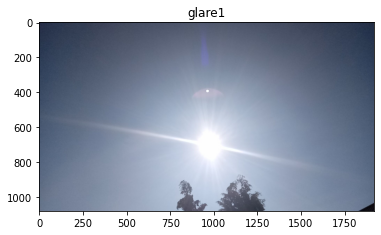

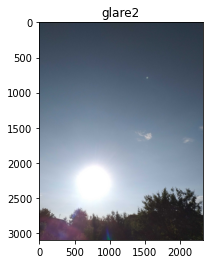

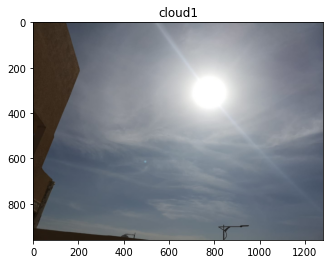

In [ ]:
# Displaying images for comparison

# Import neccessary library
import cv2

im = cv2.imread('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Outliers/Copy of glare1.jpg')
# Resizes image
im_resized = cv2.resize(im, (1920, 1080), interpolation=cv2.INTER_LINEAR)
# Gives the image a title
plt.title('glare1')

# Displays image
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

im = cv2.imread('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Outliers/Copy of glare2.jpg')
im_resized = cv2.resize(im, (2322, 3096), interpolation=cv2.INTER_LINEAR)
plt.title('glare2')

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

im = cv2.imread('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Outliers/Copy of cloud1.jpg')
im_resized = cv2.resize(im, (1280, 960), interpolation=cv2.INTER_LINEAR)
plt.title('cloud1')

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

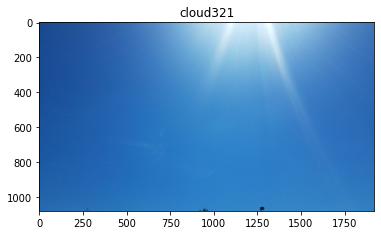

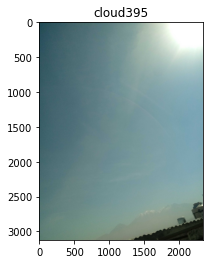

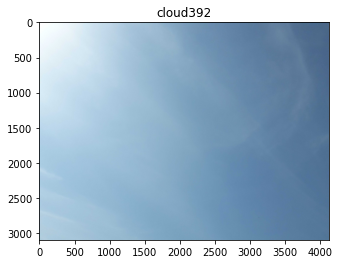

In [ ]:
im = cv2.imread('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Outliers/Copy of cloud321.jpg')
im_resized = cv2.resize(im, (1920, 1080), interpolation=cv2.INTER_LINEAR)
plt.title('cloud321')

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

im = cv2.imread('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Outliers/Copy of cloud395.jpg')
im_resized = cv2.resize(im, (2340, 3120), interpolation=cv2.INTER_LINEAR)
plt.title('cloud395')

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

im = cv2.imread('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Outliers/Copy of cloud392.jpg')
im_resized = cv2.resize(im, (4128, 3096), interpolation=cv2.INTER_LINEAR)
plt.title('cloud392')

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()


### Results
I created a confusion matrix to display the results as well as the accuracy and prescision scores. My model was 81% accurate in differentiating cloudy and clear images. It was most accurate when it classified clear sky images because the precision score was 86%. Meaning, 185 out of the 216 images were correctly classified. However, when it came to classifying cloudy images, the model wasn't as accurate. The precision score was around 75% since 140 out of the 187 images were correctly identified. Perhaps because there is so much variation with cloud photos and many variables may affect these images such as weather, lighting, position of the photo, etc. On the bright side, the accuracy score for identifying clouds was 82%. Overall, my model was pretty accurate, though it could be improved further by adding more unique training images.

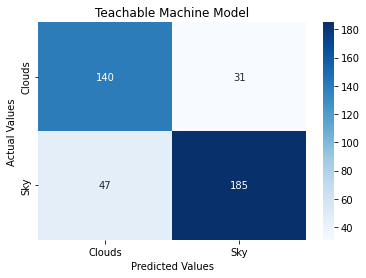

The accuracy score of the model is 0.8064516129032258
The precision score for predicting cloudy skies is 0.7486631016042781
The precision score for predicting clear skies is 0.8564814814814815


In [ ]:
import seaborn as sebrn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

true_labels = true_cloud + true_sky
pred_labels = cloudy_1 + sky_1
conf_matrix = (confusion_matrix(true_labels, pred_labels, labels=[0, 1]))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

# labels the title and x, y axis of plot
fx.set_title('Teachable Machine Model');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values');

# labels the boxes
fx.xaxis.set_ticklabels(['Clouds', 'Sky'])
fx.yaxis.set_ticklabels(['Clouds', 'Sky'])

plt.show()

# We want to see how accurate our model was in its predictions
accuracy = accuracy_score(true_labels, pred_labels)
print("The accuracy score of the model is " + str(accuracy))

# We can also see how precise the model was 
precision = precision_score(true_labels, pred_labels, average=None)
print("The precision score for predicting cloudy skies is " + str(precision[0]))
print("The precision score for predicting clear skies is " + str(precision[1]))

### Presentation Demo
This cell is mainly for the presentation demo. This photo had all of the obstructions removed then it was passed through my Teachable Machine Model. 

In [ ]:
print('Model:')
print('Prediction:')
cloudy_1 = getprediction('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Presentation Demo Image/', model1)[1]
print(getprediction('/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Presentation Demo Image/', model1)[1])


Model:
Prediction:
{'Cloud': 1, 'Sky': 0}


### Random Image Generator 
This is a fairly recent addition to this notebook but I did want to test it so I added it at the very end. The two cells below will randomly pull an image from the Cloud and Sky folders so users can compare the images. The code can definitely be improved and shortened but it gets the point across. There is an occasional issue: "IndexError: Cannot choose from an empty sequence." But after running the cell again, it will resume working properly and display a new image. 

/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Actual (Matrix)/Cloud/glare2.jpg


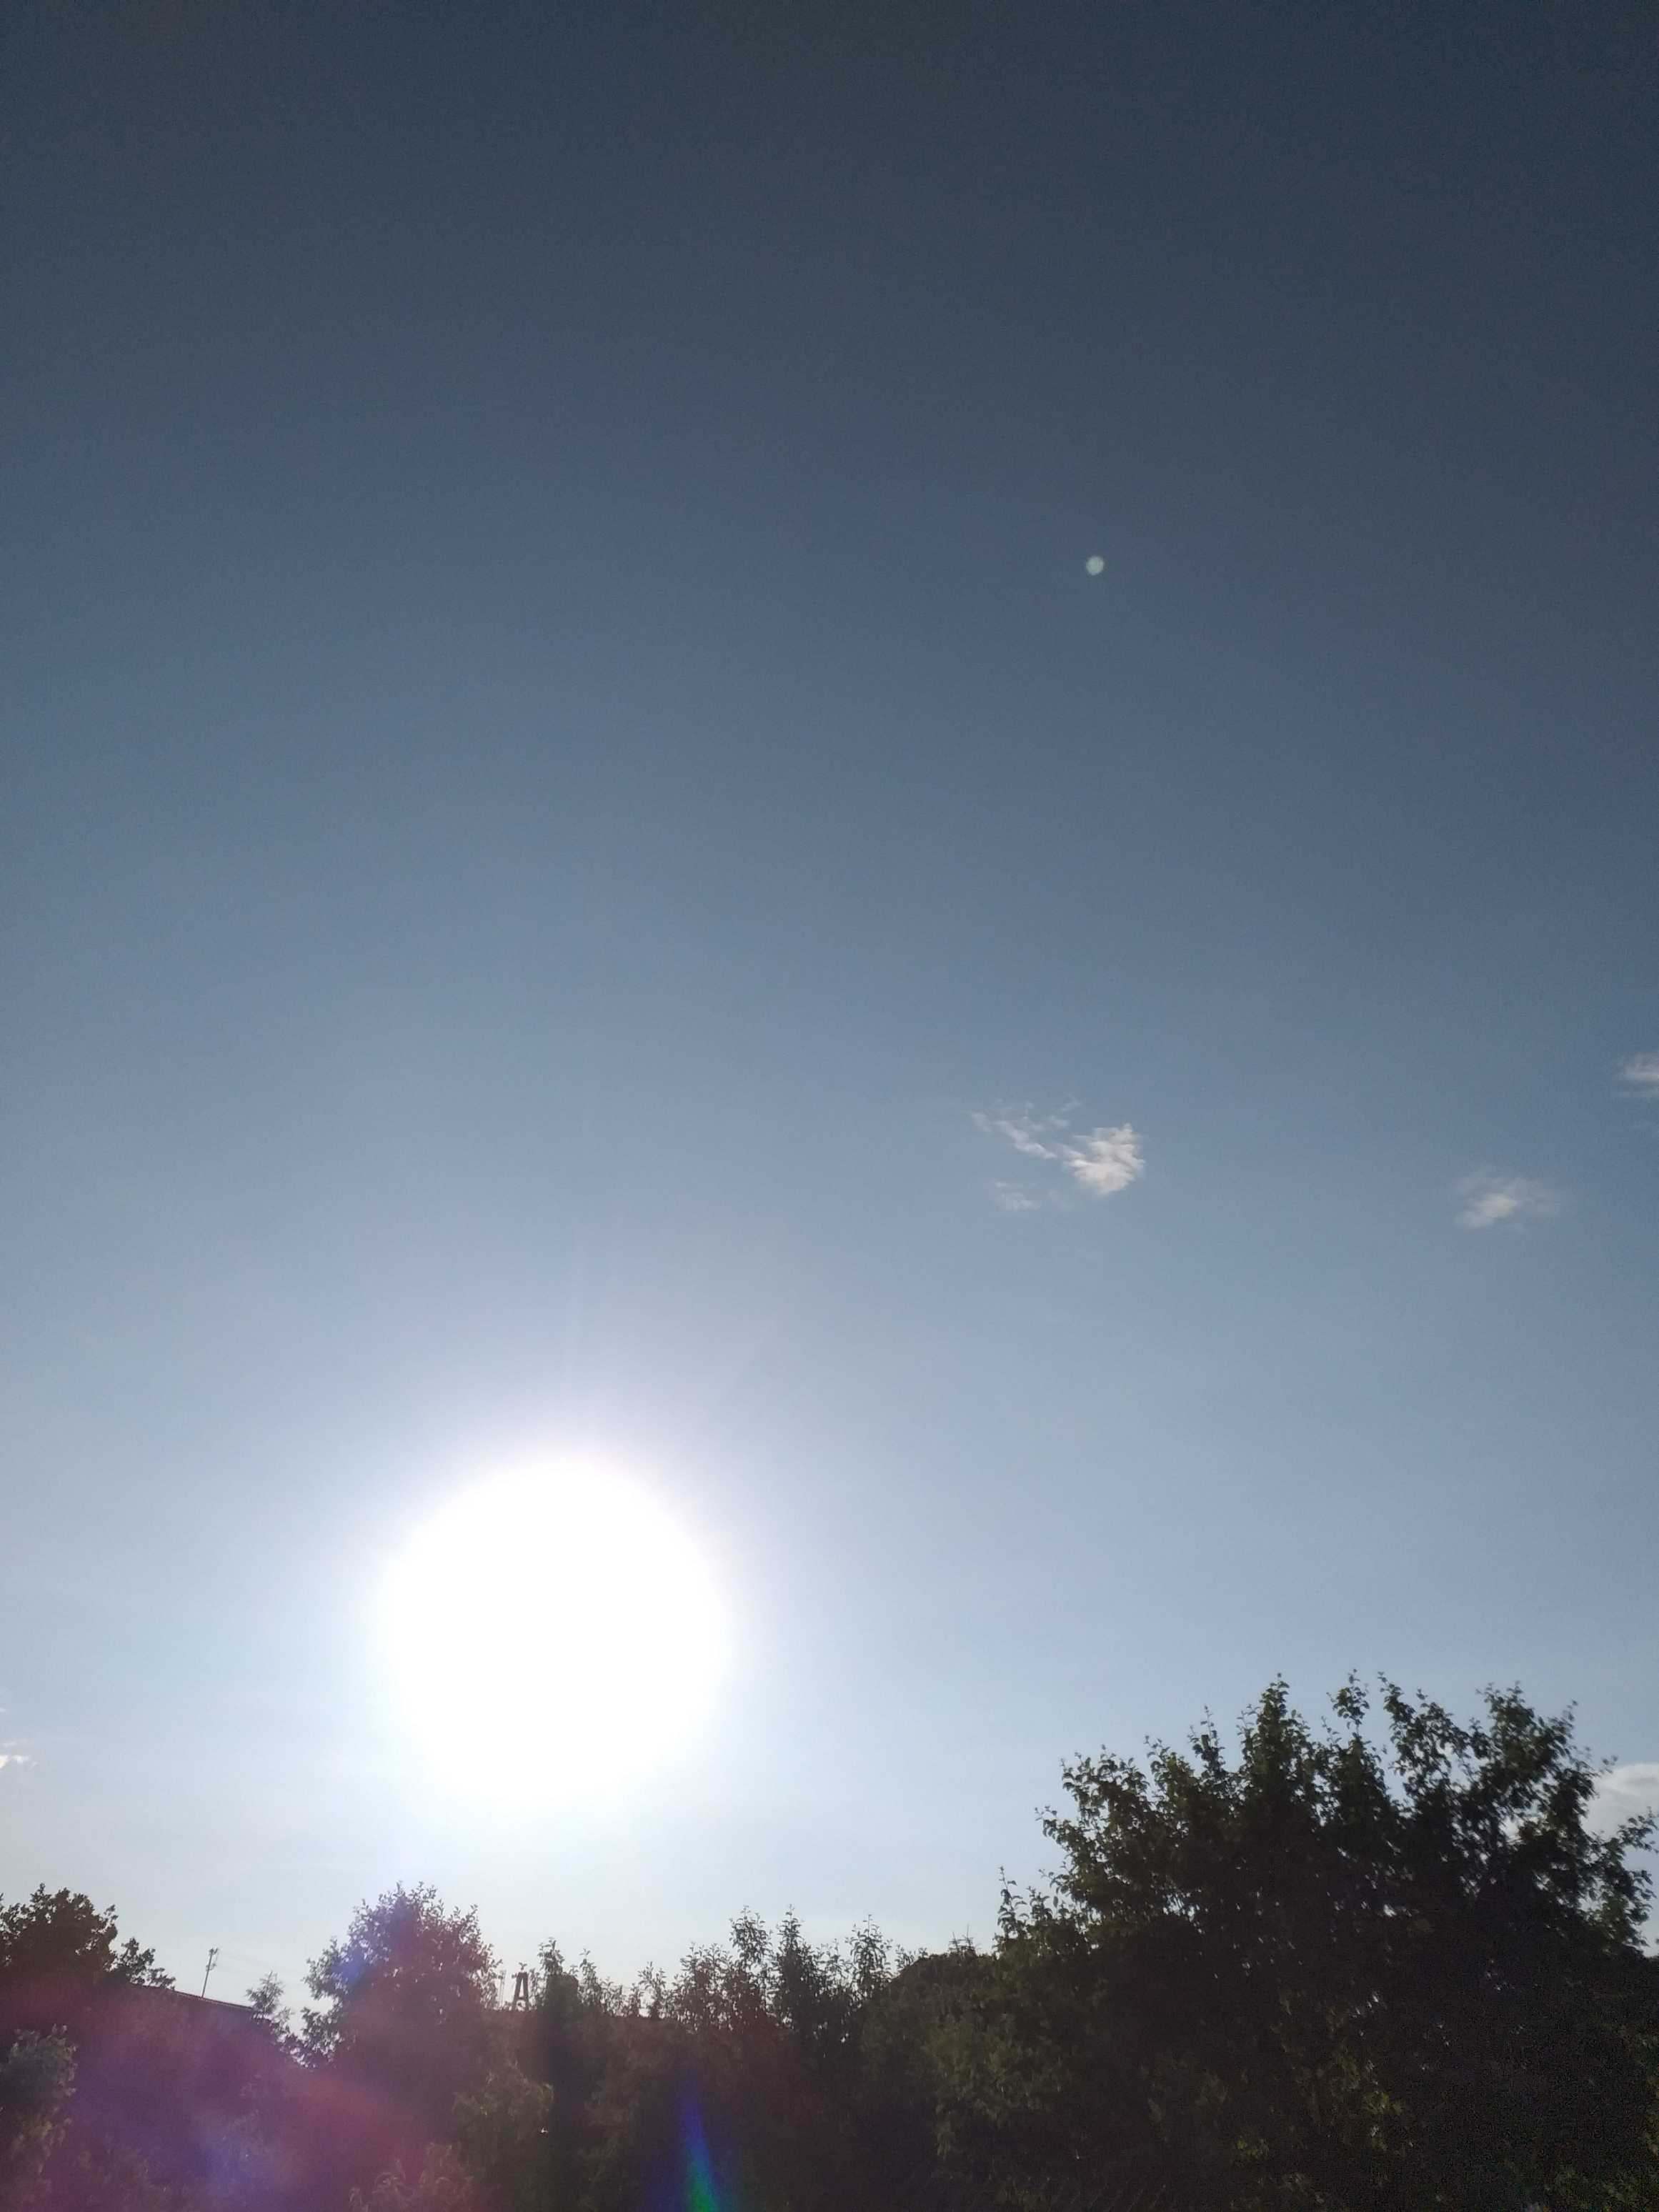

In [ ]:
import glob, random
file_path_type = ["/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Actual (Matrix)/Cloud/*.jpeg",
                  "/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Actual (Matrix)/Cloud/*.jpg"]
images = glob.glob(random.choice(file_path_type))
random_image = random.choice(images)
print(random_image)
Image.open(random_image)

In [ ]:
file_path_type = ["/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Actual (Matrix)/Sky/*.jpeg",
                  "/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Actual (Matrix)/Sky/*.jpg"]
images = glob.glob(random.choice(file_path_type))
random_image = random.choice(images)
print(random_image)
Image.open(random_image)

/content/gdrive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Real Data/Actual (Matrix)/Sky/cloud146.jpg
